# Modeling Notebook - Positive/Negative Classifier

In [30]:
# Import the required libraries
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer

import string
import re
import wordcloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline 

from imblearn.over_sampling import RandomOverSampler
import imblearn.pipeline as imblearnpipeline

import pandas as pd
import numpy as np
from PIL import Image
from os import path

import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

from myFunctions import process_tweet_text_encode_to_ascii
from myFunctions import get_social_media_stopwords_list
from myFunctions import plot_word_cloud
from myFunctions import clean_tweet, tokenize_tweet, tokenize_lemmatize_tweet
from myFunctions import show_peformance_metrics, plot_pretty_cf

np.random.seed(42)

In [31]:
# read in the processed data
pos_tweets = pd.read_csv('../data/cleaned_tweets_positive.csv', encoding = 'unicode_escape')
print(pos_tweets.shape)

neg_tweets = pd.read_csv('../data/cleaned_tweets_negative.csv', encoding = 'unicode_escape')
print(neg_tweets.shape)

neutral_tweets = pd.read_csv('../data/cleaned_tweets_neutral.csv', encoding = 'unicode_escape')
print(neutral_tweets.shape)

all_tweets = pd.read_csv('../data/cleaned_tweets_all.csv')
print(all_tweets.shape)

(2861, 7)
(544, 7)
(5293, 7)
(8698, 7)


## Corpus Exploration
* What are the most common words found in Positive, Negative and Neutral Tweets?

In [32]:
# Create word clouds of the most common words in Positive, Negative (and Neutral) Tweets
# Note: no lemma done here
positive_tweet_words = list()
for tweet in pos_tweets['tweet_text'].to_list():
    processed_tweet = process_tweet_text_encode_to_ascii(tweet, get_social_media_stopwords_list())
    for word in processed_tweet:
        positive_tweet_words.append(word)

negative_tweet_words = list()
for tweet in neg_tweets['tweet_text'].to_list():
    processed_tweet = process_tweet_text_encode_to_ascii(tweet, get_social_media_stopwords_list())
    for word in processed_tweet:
        negative_tweet_words.append(word)

neutral_tweet_words = list()
for tweet in neutral_tweets['tweet_text'].to_list():
    processed_tweet = process_tweet_text_encode_to_ascii(tweet, get_social_media_stopwords_list())
    for word in processed_tweet:
        neutral_tweet_words.append(word)


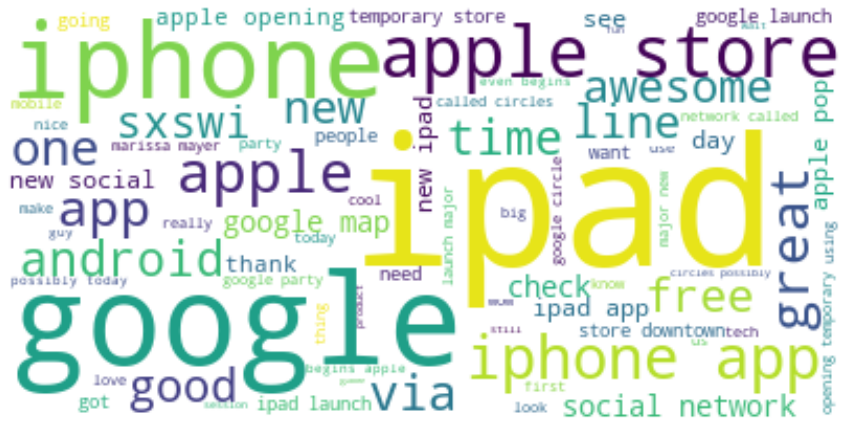

In [33]:
# Postive Tweets top 50 words
positive_text = ' '.join(word for word in positive_tweet_words)
plot_word_cloud(positive_text, 75, get_social_media_stopwords_list(), 'white')

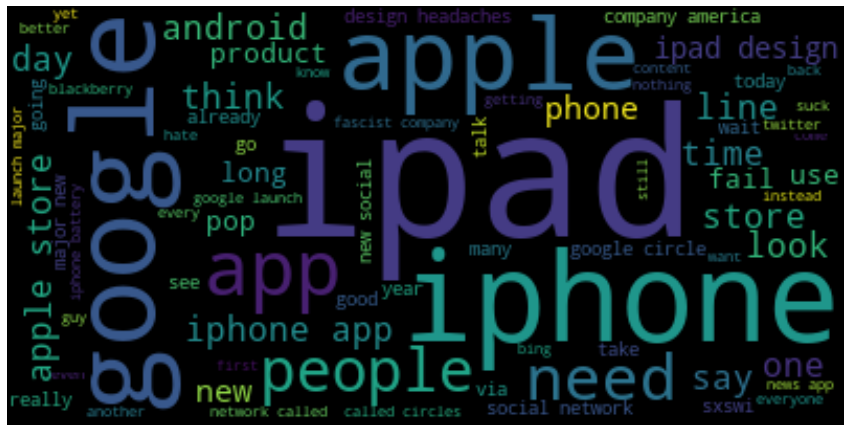

In [34]:
# Negative Tweets top 50 words
negative_text = ' '.join(word for word in negative_tweet_words)
plot_word_cloud(negative_text, 75, get_social_media_stopwords_list())

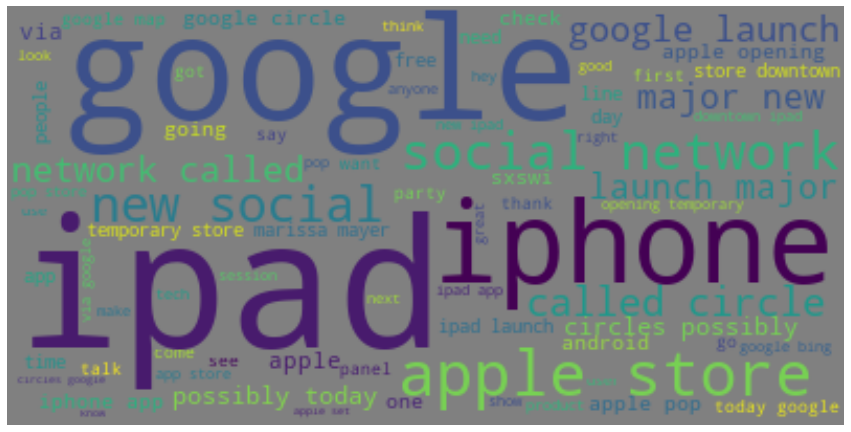

In [35]:
# Neutral Tweets top 50 words
neutral_text = ' '.join(word for word in neutral_tweet_words)
plot_word_cloud(neutral_text, 75, get_social_media_stopwords_list(), 'grey')

## Text Processing 

In [36]:
# clean the tweets before performing TD-IDF vetgorization
#all_tweets['tweet_text'] = all_tweets.apply(lambda row: clean_tweet(row['tweet_text']), axis=1)
all_tweets['tweet_text'] = all_tweets['tweet_text'].apply(clean_tweet)
display(all_tweets['tweet_text'].head(5))


0    .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1    @jessedee Know about @fludapp ? Awesome iPad/i...
2    @swonderlin Can not wait for iPad 2 also. They...
3    @sxsw I hope this year's festival isn't as cra...
4    @sxtxstate great stuff on Fri SXSW: Marissa Ma...
Name: tweet_text, dtype: object

## Processing Done..let's get ready to build some Classification Models

In [37]:
##
# - Create TRAIN and TEST data sets from the Postive and Negative Tweet datasets.
# - Separate the data (tweet_text) and the labels (sentiment) in both TRAIN and TEST
# - Process the TRAIN tweets
# - Explore TRAIN data with Freq Dist?
# - Vectorize TRAIN with sklearn
# - Create a basic model (try MultinomialNB and RandomForestClassifier )
# - Fit each to our vectorized training data
# - Create predictions for TRAIN and TEST sets
# - Calculate the accuracy_score() for both TRAIN and TEST 
# - Experiment with model tuning AND/OR other model choices
#
# The data is imbalanced, use the weighted F1 score to analyze our models' performance

In [38]:
corpus_binary = all_tweets[all_tweets['sentiment'] != 'Neutral']['tweet_text'].tolist()
labels_binary = all_tweets[all_tweets['sentiment'] != 'Neutral']['sentiment'].tolist()

X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(corpus_binary, labels_binary, test_size=0.2, random_state=42)

print(len(X_train_binary), len(y_train_binary), len(X_test_binary), len(y_test_binary))


2724 2724 681 681


In [39]:
# Text Processing - TF-IDF
# Use TF_IDF to focus on words that appear heavily in tweets from a given class, but rarely appear in tweets from other class/classes.

# Use tokenzer for tweets and the customized stopwords list
tfidvectorizer_for_binary = TfidfVectorizer(tokenizer=tokenize_lemmatize_tweet, 
                                        stop_words=get_social_media_stopwords_list(), 
                                        strip_accents='ascii',
                                        decode_error='ignore')

# Fit on TRAIN data
tf_idf_data_train_binary = tfidvectorizer_for_binary.fit_transform(X_train_binary)
# Creat a vectorized version of the TEST data
tf_idf_data_test_binary = tfidvectorizer_for_binary.transform(X_test_binary)

In [40]:
# TF-IDF - Let's check out the vocab for the ENTIRE corpus of Pos and Neg Tweets...Train and Test
print(len(tfidvectorizer_for_binary.vocabulary_.keys()))

4872


In [41]:
# Let's see what terms were important
# print idf values 
df_idf = pd.DataFrame(tfidvectorizer_for_binary.idf_, index=tfidvectorizer_for_binary.get_feature_names(),columns=["idf_weights"]) 
 
df_idf.sort_values(by=['idf_weights'], ascending=False)[:10]

,idf_weights
jzsxsw,8.217077
mb,8.217077
martini,8.217077
marty,8.217077
mary,8.217077
masha,8.217077
mastered,8.217077
mater,8.217077
matthew,8.217077
mavis,8.217077


## Models!

In [42]:
nb_classifier_binary = Pipeline([  ('tfidf_vec', tfidvectorizer_for_binary),
                            ('clf', MultinomialNB()) ])

nb_classifier_binary.fit(X_train_binary, y_train_binary)

nb_classifier_binary_train_predictions = nb_classifier_binary.predict(X_train_binary)
nb_classifier_binary_test_predictions = nb_classifier_binary.predict(X_test_binary)

nb_classifier_binary_train_score = accuracy_score(y_train_binary, nb_classifier_binary_train_predictions)
nb_classifier_binary_test_score = accuracy_score(y_test_binary, nb_classifier_binary_test_predictions)

In [43]:
show_peformance_metrics(y_train_binary, 
                        nb_classifier_binary_train_predictions, 
                        X_train_binary, 
                        y_test_binary,
                        nb_classifier_binary_test_predictions, 
                        ['Negative', 'Positive'])

--------------------------------------------------------------------------
Training Accuracy: 0.8598 		 Testing Accuracy: 0.8678
--------------------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       1.00      0.08      0.15        98
    Positive       0.87      1.00      0.93       583

    accuracy                           0.87       681
   macro avg       0.93      0.54      0.54       681
weighted avg       0.89      0.87      0.82       681

--------------------------------------------------------------------------


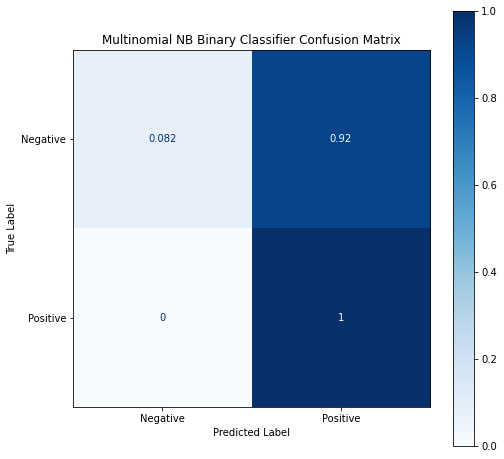

In [44]:
plot_pretty_cf(nb_classifier_binary, X_test_binary, y_test_binary, title='Multinomial NB Binary Classifier Confusion Matrix')

In [45]:
# Try RandomForest
rf_clf_binary = Pipeline([ ('tfidf_vec', tfidvectorizer_for_binary),
                           ('clf', RandomForestClassifier(n_estimators=100) )])

rf_clf_binary.fit(X_train_binary, y_train_binary)

rf_clf_binary_train_predictions = rf_clf_binary.predict(X_train_binary)
rf_clf_binary_test_predictions = rf_clf_binary.predict(X_test_binary)


In [46]:
show_peformance_metrics(y_train_binary, 
                        rf_clf_binary_train_predictions, 
                        X_train_binary, 
                        y_test_binary,
                        rf_clf_binary_test_predictions, 
                        ['Negative', 'Positive'])

--------------------------------------------------------------------------
Training Accuracy: 0.9982 		 Testing Accuracy: 0.8884
--------------------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.82      0.29      0.42        98
    Positive       0.89      0.99      0.94       583

    accuracy                           0.89       681
   macro avg       0.86      0.64      0.68       681
weighted avg       0.88      0.89      0.86       681

--------------------------------------------------------------------------


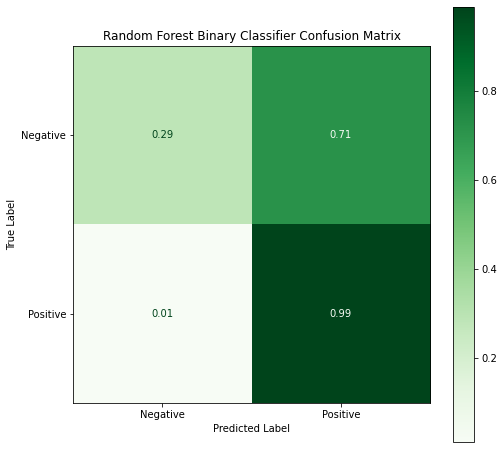

In [47]:
plot_pretty_cf(rf_clf_binary, X_test_binary, y_test_binary, cmap='Greens', title='Random Forest Binary Classifier Confusion Matrix')

### Random Forest was better than NB...but still pretty crummy due to a high number of False Negatives: incorrectly classifed a Negative sentiment tweet as a Positive sentitment tween. Also, there is MASSIVE overfitting.

In [48]:
# Try LinearSVC
svc_clf_binary = Pipeline([ ('tfidf_vec', tfidvectorizer_for_binary),
                            ('clf', LinearSVC()) ])

svc_clf_binary.fit(X_train_binary, y_train_binary)

svc_binary_train_predictions = svc_clf_binary.predict(X_train_binary)
svc_binary_test_predictions = svc_clf_binary.predict(X_test_binary)

In [49]:
show_peformance_metrics(y_train_binary, svc_binary_train_predictions, X_test_binary, y_test_binary, svc_binary_test_predictions, ['Negative', 'Positive'])

--------------------------------------------------------------------------
Training Accuracy: 0.993 		 Testing Accuracy: 0.8913
--------------------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.69      0.44      0.54        98
    Positive       0.91      0.97      0.94       583

    accuracy                           0.89       681
   macro avg       0.80      0.70      0.74       681
weighted avg       0.88      0.89      0.88       681

--------------------------------------------------------------------------


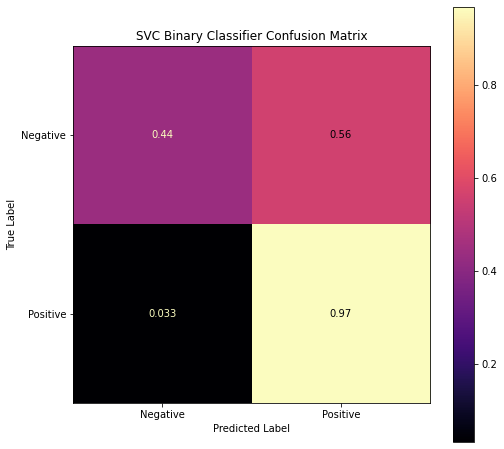

In [50]:
plot_pretty_cf(svc_clf_binary, X_test_binary, y_test_binary, cmap='magma', title='SVC Binary Classifier Confusion Matrix')

## Let's try to address the class imbalance. 

The corpus used to train this Binary classifier has two classes, Positive (84% of tweets) and Negative (16% of tweets). The Negative class is under-represented. 

A quick (and basic) way to address class imbalance is to *oversample the under-represented class*. 

"Random oversampling duplicates examples from the minority class in the training dataset and can result in overfitting for some models.  Random oversampling can be used for two-class (binary) classification problems and multi-class classification problems with one or more majority or minority classes.

Importantly, the change to the class distribution is only applied to the training dataset. The intent is to influence the fit of the models. The resampling is not applied to the test or holdout dataset used to evaluate the performance of a model."

 More details [here] (https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/) 


In [51]:
# Create an imblearn Pipeline to apply the RandomeOverSampler to our minority class, Negative.

oversampler = RandomOverSampler(sampling_strategy='minority',random_state=7)

text_clf = imblearnpipeline.Pipeline([('tfidf_vec', tfidvectorizer_for_binary), 
                                        ('rus', oversampler),
                                        ('clf', MultinomialNB())])

text_clf = text_clf.fit(X_train_binary, y_train_binary)

y_pred = text_clf.predict(X_test_binary)
y_train_pred = text_clf.predict(X_train_binary)

In [52]:
show_peformance_metrics(y_train_binary, y_train_pred, X_test_binary, y_test_binary, y_pred, ['Negative', 'Positive'])

--------------------------------------------------------------------------
Training Accuracy: 0.9479 		 Testing Accuracy: 0.8326
--------------------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.45      0.71      0.55        98
    Positive       0.95      0.85      0.90       583

    accuracy                           0.83       681
   macro avg       0.70      0.78      0.72       681
weighted avg       0.88      0.83      0.85       681

--------------------------------------------------------------------------


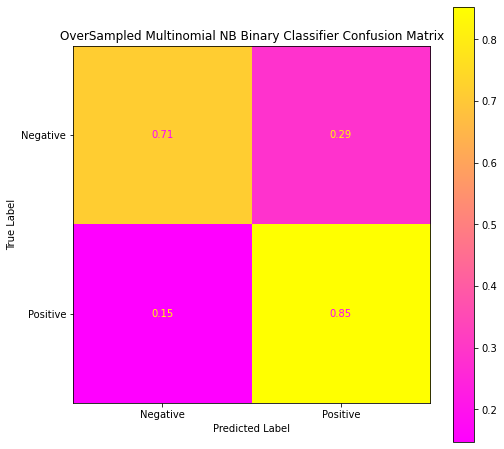

In [53]:
plot_pretty_cf(text_clf, X_test_binary, y_test_binary, cmap='spring', title='OverSampled Multinomial NB Binary Classifier Confusion Matrix')